In [21]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

Q1_QRELS_FILE = "../query_qrels_M3/query_1.txt"
Q2_QRELS_FILE = "../query_qrels_M3/query_2.txt"
Q3_QRELS_FILE = "../query_qrels_M3/query_3.txt"



#System 2
Q1 = "http://localhost:8983/solr/medicines/select?debug.explain.structured=true&debugQuery=false&defType=edismax&indent=true&q.op=AND&q=nao%20tomar%20gravidez&qf=Antes_de_utilizar&qs=4&rows=100&useParams=&wt=json"
Q2 = "http://localhost:8983/solr/medicines/select?debug.explain.structured=true&debugQuery=false&defType=edismax&indent=true&q.op=AND&q=Bioflavonóides%20para%20vascular&qf=Substancia_Ativa_DCI%5E4%20Active_substance%5E4%20Product_Name%5E3%20O_que_e_e_para_que_e_utilizado%5E3&rows=100&stopwords=false&useParams=&wt=json"
Q3 = "http://localhost:8983/solr/medicines/select?debug.explain.structured=true&debugQuery=false&defType=edismax&fq=Vias_de_Administracao%3A%22Via%20oral%22&indent=true&q.op=AND&q=alivio%20dores&qf=O_que_e_e_para_que_e_utilizado&qs=4&rows=100&useParams=&wt=json"


#Systen 4
SQ1_q = "nao tomar gravidez"
SQ1_k = 10

SQ2_q = "Bioflavonóides para vascular"
SQ2_k = 10

SQ3_q = "alívio dores oral"
SQ3_k = 10


QUERY_URL = SQ3_q
Query_k = SQ3_k
QRELS_FILE = Q3_QRELS_FILE
SEMANTIC_FLAG = True

In [22]:
from query_embedding import get_response

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))
# Get query results from Solr instance
if(SEMANTIC_FLAG):
    results = get_response(QUERY_URL, topK=Query_k).get("response", {}).get("docs", [])
else:
    results = requests.get(QUERY_URL).json()['response']['docs']

print(results)
print('Returned:',len(results))

[{'Product_name': ['Bendalina'], 'Substancia_Ativa_DCI': 'Bendazac', 'Generico': 'Não', 'Vias_de_Administracao': 'Uso oftálmico', 'Duracao_do_Tratamento': 'Curta ou Média Duração'}, {'Product_name': ['Bendalina'], 'Substancia_Ativa_DCI': 'Bendazac', 'Generico': 'Não', 'Vias_de_Administracao': 'Uso oftálmico', 'Duracao_do_Tratamento': 'Curta ou Média Duração'}, {'Product_name': ['Azyter'], 'Substancia_Ativa_DCI': 'Azitromicina', 'Generico': 'Não', 'Vias_de_Administracao': 'Uso oftálmico', 'Duracao_do_Tratamento': 'Curta ou Média Duração'}, {'Product_name': ['Allergodil'], 'Substancia_Ativa_DCI': 'Azelastina', 'Generico': 'Não', 'Vias_de_Administracao': 'Uso oftálmico', 'Duracao_do_Tratamento': 'Curta ou Média Duração', 'O_que_e_e_para_que_e_utilizado': 'O que é Allergodil e para que é utilizado\nAllergodil contém a substância ativa cloridrato de azelastina, que pertence ao grupo\nde medicamentos denominados antialérgicos (anti-histamínicos). Os\nanti-histamínicos atuam prevenindo o efei

In [23]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        if doc['Product_name'][0] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['Product_name'][0] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

In [24]:
# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
    [
        [evaluation_metrics[m], calculate_metric(m, results, relevant)]
        for m in evaluation_metrics
    ]
)

with open('results.tex','w') as tf:
    tf.write(df.to_latex())


/var/folders/vs/5lnkycfx3cqfxdsgh773jtw80000gn/T/ipykernel_51170/2291209027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())


'Precision values:'

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.14285714285714285,
 0.125,
 0.1111111111111111,
 0.1]

'Recall values:'

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091,
 0.09090909090909091]

'MY Interpolated Recall'

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

'Interpolated precision'

[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

'My Interpolated precision'

[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

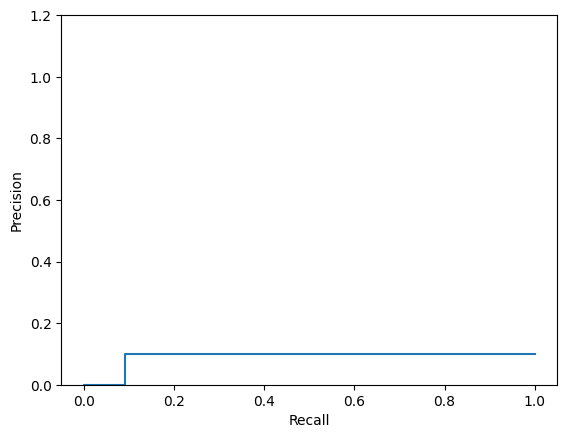

<Figure size 640x480 with 0 Axes>

In [25]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc 
        for doc in results[:idx]
        if doc['Product_name'][0] in relevant
    ]) / idx 
    for idx, _ in enumerate(results, start=1)
]

recall_values = [
    len([
        doc for doc in results[:idx]
        if doc['Product_name'][0] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(results, start=1)
]

display("Precision values:", precision_values)
display("Recall values:", recall_values)

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}


# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.0, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))


my_interpolated_recall = [step for step in np.arange(0.0, 1.1, 0.1)]
display("MY Interpolated Recall", my_interpolated_recall)


# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            if recall_values[idx+1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]
            else:
                precision_recall_match[step] = precision_recall_match[recall_values[idx+2]]


disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)

my_interpolated_precision = [precision_recall_match.get(r) for r in my_interpolated_recall]
display("Interpolated precision", [precision_recall_match.get(r) for r in recall_values])
display("My Interpolated precision", my_interpolated_precision)


disp.plot()
plt.ylim(0, 1.2)
plt.show()
plt.savefig('precision_recall.png')
